In [1]:

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import torch
from torchvision import transforms
from pytorch_i3d import InceptionI3d
from tgcn_model import GCN_muti_att
import json

In [2]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def extract_keypoints_max(results):
    keypoints = []
    if results.pose_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]))
    if results.face_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.face_landmarks.landmark]))
    if results.left_hand_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]))
    if results.right_hand_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]))
    return np.concatenate(keypoints) if len(keypoints)>0 else np.array([])

In [5]:
def compute_difference(x):
    diff = []

    for i, xx in enumerate(x):
        temp = []
        for j, xxx in enumerate(x):
            if i != j:
                temp.append(xx - xxx)

        diff.append(temp)

    return diff


In [6]:
def midpoint(p1, p2):
        return np.array([(p1[0]+p2[0])/2, (p1[1]+p2[1])/2])
    

In [107]:
def extract_keypoints(results):
    pose = np.array([[landmark.x, landmark.y] for landmark in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,2))
    neck = midpoint(pose[11], pose[12])
    hips = midpoint(pose[23], pose[24])
    pose = np.append(pose, np.array([neck, hips]), axis = 0)[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]
    for i, point in enumerate(pose):
        if any(x > 1 or x < 0 for x in point):
            pose[i] = [0, 0]
    lh = np.array([[landmark.x, landmark.y] for landmark in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,2))
    rh = np.array([[landmark.x, landmark.y] for landmark in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21,2))

    return torch.FloatTensor((np.concatenate([pose, lh, rh])-0.5)*2)

In [8]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    

In [9]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [10]:
def generate_bounding_box(keypoints, frame):
  transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 325)),
          transforms.CenterCrop(224),
          transforms.ToTensor()
      ])
  input_img = transform(frame)
  if keypoints.size > 0:
    H, W, _ = frame.shape
    x_vals = []
    y_vals = []
    for lm in keypoints:
      x = int(lm[0] * W)
      y = int(lm[1] * H)
      x_vals.append(x)
      y_vals.append(y)
          
      min_x = min(x_vals) - 60 if min(x_vals) - 60 >= 0 else 0
      max_x = max(x_vals) + 60 if max(x_vals) + 60 <= W else W
      min_y = min(y_vals) - 60 if min(y_vals) - 60 >= 0 else 0
      max_y = max(y_vals) + 60 if max(y_vals) + 60 <= H else H


      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Lambda(lambda img: transforms.functional.crop(img, min_y, min_x, max_y - min_y, max_x - min_x)),
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])

      input_img = transform(frame)
  return input_img

      # results = pose.process(frame).pose_landmarks
      # if results:
      #   # keypoints = np.array([[res.x, res.y] for res in results.landmark])
      #   rs = results.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
      #   ls = results.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value]

      # mp_drawing.draw_landmarks(frame, results, mp.solutions.pose.POSE_CONNECTIONS,
      #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
      #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
      #                          ) 
      # cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 0, 0), 4)

In [11]:
def vid_to_tensor(video_path, start=0, num=-1):
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
  if num == -1:
    num = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = []
  for offset in range(num):
    success, img = vidcap.read()
    if not success:
      continue

    w, h, c = img.shape
    sc = 224 / w
    img = cv2.resize(img, dsize=(0, 0), fx=sc, fy=sc)
    img = (img / 255.) * 2 - 1
    img = transforms.CenterCrop(224)(torch.Tensor(img.transpose([2, 0, 1])))
    frames.append(img)
  
  return torch.from_numpy(np.expand_dims(np.asarray(frames, dtype=np.float32).transpose([1, 0, 2, 3]), axis = 0))

In [67]:
def vid_to_mp(video_path, start=0, num=-1):
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
  if num == -1:
    num = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(num)

  frames = []
  mp_holistic = mp.solutions.holistic 
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for offset in range(num):
      success, img = vidcap.read()
      if not success:
        continue

      w, h, c = img.shape

      image, results = mediapipe_detection(img, holistic)

      keypoints = extract_keypoints(results)
      frames.append(keypoints)
  
  return frames

In [12]:
def tensor_to_imgs(input):
  img = np.array(input[0].flip(0))
  img = (img + 1) / 2
  return img.transpose([1, 2, 3, 0])

In [13]:
def from_video(vid_path, model, labels):
  sentence = []
  threshold = 0.05

  video = vid_to_tensor(vid_path)
  frames = video.shape[2]
  i = 0
  while i < frames:
    end1 = 30 if i + 30 < frames else frames - i
    end2 = 60 if i + 60 < frames else frames - i

    word = ''

    if end1 > 10:
      chunk1 = video[:, :, i:i+end1, :, :]
      per_frame_logits1 = model(chunk1)
      predictions1 = torch.max(per_frame_logits1, dim=2)[0]
      p1, k1 = torch.nn.functional.softmax(predictions1, dim = 1).topk(1, dim = 1)
      if(p1[0,0].item()>threshold):
        print('1')
        i = i+end1
        word = labels[k1[0,0].item()]
    if end2 > 10 and word != '':
      chunk2 = video[:, :, i:i+end2, :, :]
      per_frame_logits2 = model(chunk2)
      predictions2 = torch.max(per_frame_logits2, dim=2)[0]
      p2, k2 = torch.nn.functional.softmax(predictions2, dim = 1).topk(1, dim = 1)
      if(p2[0,0].item()>threshold):
        print('2')
        i = i+end2
        word = labels[k2[0,0].item()]
    if word == '':
      i+=5
    else:
      sentence.append(word)
      
    if(end1 != 30):
      break

  return sentence

In [14]:
def from_recording(model, labels):
  sequence = []
  record = False
  cap = cv2.VideoCapture(0)
  
  while cap.isOpened():
    success, frame = cap.read()
    if record:
      img = frame
      w, h, c = img.shape
      sc = 224 / w
      img = cv2.resize(img, dsize=(0, 0), fx=sc, fy=sc)
      img = (img / 255.) * 2 - 1
      img = transforms.CenterCrop(224)(torch.Tensor(img.transpose([2, 0, 1])))
      sequence.append(img)

    cv2.imshow('OpenCV Feed', frame)

    key = cv2.waitKey(10)
    if key & 0xFF == ord(' '):
      if not record:
        print("Recording...")
        record = True
      else:
        print("End recording")
        break
    if key & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

  video = torch.from_numpy(np.expand_dims(np.asarray(sequence, dtype=np.float32).transpose([1, 0, 2, 3]), axis = 0))

  sentence = []
  threshold = 0.05
  frames = video.shape[2]
  i = 0
  while i < frames:
    end1 = 30 if i + 30 < frames else frames - i
    end2 = 60 if i + 60 < frames else frames - i

    word = ''

    if end1 > 10:
      chunk1 = video[:, :, i:i+end1, :, :]
      per_frame_logits1 = model(chunk1)
      predictions1 = torch.max(per_frame_logits1, dim=2)[0]
      p1, k1 = torch.nn.functional.softmax(predictions1, dim = 1).topk(1, dim = 1)
      if(p1[0,0].item()>threshold):
        i = i+end1
        word = labels[k1[0,0].item()]
    if end2 > 10 and word != '':
      chunk2 = video[:, :, i:i+end2, :, :]
      per_frame_logits2 = model(chunk2)
      predictions2 = torch.max(per_frame_logits2, dim=2)[0]
      p2, k2 = torch.nn.functional.softmax(predictions2, dim = 1).topk(1, dim = 1)
      if(p2[0,0].item()>threshold):
        i = i+end2
        word = labels[k2[0,0].item()]
    if word == '':
      i+=5
    else:
      sentence.append(word)

    
    if(end1 != 30):
      break

  return sentence

In [15]:
def read_pose_file(filepath):
    body_pose_exclude = {9, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24}

    try:
        content = json.load(open(filepath))["people"][0]
    except IndexError:
        return None

    path_parts = os.path.split(filepath)

    frame_id = path_parts[1][:11]
    vid = os.path.split(path_parts[0])[-1]

    save_to = os.path.join('/home/dxli/workspace/nslt/code/Pose-GCN/posegcn/features', vid)

    try:
        ft = torch.load(os.path.join(save_to, frame_id + '_ft.pt'))

        xy = ft[:, :2]
        # angles = torch.atan(ft[:, 110:]) / 90
        # ft = torch.cat([xy, angles], dim=1)
        return xy

    except FileNotFoundError:
        print(filepath)
        body_pose = content["pose_keypoints_2d"]
        left_hand_pose = content["hand_left_keypoints_2d"]
        right_hand_pose = content["hand_right_keypoints_2d"]

        body_pose.extend(left_hand_pose)
        body_pose.extend(right_hand_pose)

        x = [v for i, v in enumerate(body_pose) if i % 3 == 0 and i // 3 not in body_pose_exclude]
        y = [v for i, v in enumerate(body_pose) if i % 3 == 1 and i // 3 not in body_pose_exclude]
        # conf = [v for i, v in enumerate(body_pose) if i % 3 == 2 and i // 3 not in body_pose_exclude]

        x = 2 * ((torch.FloatTensor(x) / 256.0) - 0.5)
        y = 2 * ((torch.FloatTensor(y) / 256.0) - 0.5)
        # conf = torch.FloatTensor(conf)

        x_diff = torch.FloatTensor(compute_difference(x)) / 2
        y_diff = torch.FloatTensor(compute_difference(y)) / 2

        zero_indices = (x_diff == 0).nonzero()

        orient = y_diff / x_diff
        orient[zero_indices] = 0

        xy = torch.stack([x, y]).transpose_(0, 1)

        ft = torch.cat([xy, x_diff, y_diff, orient], dim=1)

        path_parts = os.path.split(filepath)

        frame_id = path_parts[1][:11]
        vid = os.path.split(path_parts[0])[-1]

        # save_to = os.path.join('code/Pose-GCN/posegcn/features', vid)
        # if not os.path.exists(save_to):
        #     os.mkdir(save_to)
        # torch.save(ft, os.path.join(save_to, frame_id + '_ft.pt'))

        xy = ft[:, :2]
        # angles = torch.atan(ft[:, 110:]) / 90
        # ft = torch.cat([xy, angles], dim=1)
        #
        return xy

In [16]:
def sequential_sampling(frame_start, frame_end, num_samples):
    """Keep sequentially ${num_samples} frames from the whole video sequence by uniformly skipping frames."""
    num_frames = frame_end - frame_start + 1

    frames_to_sample = []
    if num_frames > num_samples:
        frames_skip = set()

        num_skips = num_frames - num_samples
        interval = num_frames // num_skips

        for i in range(frame_start, frame_end + 1):
            if i % interval == 0 and len(frames_skip) <= num_skips:
                frames_skip.add(i)

        for i in range(frame_start, frame_end + 1):
            if i not in frames_skip:
                frames_to_sample.append(i)
    else:
        frames_to_sample = list(range(frame_start, frame_end + 1))

    return frames_to_sample

In [127]:
def load_poses(video_id, frame_start, frame_end, num_samples):
        """ Load frames of a video. Start and end indices are provided just to avoid listing and sorting the directory unnecessarily.
         """
        poses = []
        
        frames_to_sample = sequential_sampling(frame_start, frame_end, num_samples)

        for i in frames_to_sample:
            pose_path = os.path.join(os.path.join('..', '..', 'WLASL', 'data', 'pose_per_individual_videos'), video_id, 'image_{}_keypoints.json'.format(str(i).zfill(5)))
            # pose = cv2.imread(frame_path, cv2.COLOR_BGR2RGB)
            pose = read_pose_file(pose_path)

            if pose is not None:
                poses.append(pose)
                print(pose.shape)
            else:
                try:
                    poses.append(poses[-1])
                except IndexError:
                    print(pose_path)

        pad = None
        print(poses)

        # if len(frames_to_sample) < num_samples:
        # if len(poses) < num_samples:
        #     num_padding = num_samples - len(frames_to_sample)
        #     last_pose = poses[-1]
        #     pad = last_pose.repeat(1, num_padding)

        # poses_across_time = torch.cat(poses, dim=1)
        # if pad is not None:
        #     poses_across_time = torch.cat([poses_across_time, pad], dim=1)

        return poses

In [128]:
posefile = read_pose_file(os.path.join('..', '..', 'WLASL', 'data', 'pose_per_individual_videos', '05729', 'image_00010_keypoints.json'))
vid = vid_to_mp(os.path.join('..', '..', 'WLASL', 'start_kit', 'raw_videos', '05729.mp4'))
vidw = load_poses('05729', 1, 45, 50)

..\..\WLASL\data\pose_per_individual_videos\05729\image_00010_keypoints.json
..\..\WLASL\data\pose_per_individual_videos\05729\image_00001_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00002_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00003_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00004_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00005_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00006_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00007_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00008_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\image_00009_keypoints.json
torch.Size([55, 2])
..\..\WLASL\data\pose_per_individual_videos\05729\

In [129]:
len(vidw)

45

In [134]:
def from_stream(model, labels):
  sequence = []
  sentence = []
  threshold = 0.4
  mp_holistic = mp.solutions.holistic 
  cap = cv2.VideoCapture(0)
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
      success, frame = cap.read()
      
      img = frame
      w, h, c = img.shape

      image, results = mediapipe_detection(frame, holistic)

      keypoints = extract_keypoints(results)
      sequence.append(keypoints)
      sequence = sequence[-50:]
      
      if len(sequence) == 50:
        input = torch.cat(sequence,  dim = 1).unsqueeze(0)
        per_frame_logits = model(input)
        p, k  = torch.nn.functional.softmax(per_frame_logits, dim = 1).topk(1, dim = 1)
        if p[0,0].item()>threshold: 
          if len(sentence) > 0: 
            if labels[k[0,0].item()] != sentence[-1]:
              sentence.append(labels[k[0,0].item()])
          else:
            sentence.append(labels[k[0,0].item()])
          if len(sentence) > 5: 
            sentence = sentence[-5:]

      cv2.rectangle(image, (0,0), (640, 40), (0, 0, 0), -1)
      cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
      cv2.imshow('OpenCV Feed', image)

      key = cv2.waitKey(10)
      if key & 0xFF == ord('q'):
        break
  cap.release()
  cv2.destroyAllWindows()
  return sentence

In [47]:
weights = os.path.join('model', '2000words.pt')
i3d = InceptionI3d(400, in_channels=3)
i3d.replace_logits(2000)
i3d.load_state_dict(torch.load(weights, map_location=torch.device('cpu'))) 
i3d.eval()
with open('labels.txt', 'r') as file:
    labels = list(map(str.strip, file.readlines()))

In [29]:
with open('labels.txt', 'r') as file:
    labels = list(map(str.strip, file.readlines()))
model = GCN_muti_att(input_feature=100, hidden_feature=256, num_class=2000, p_dropout=0.3, num_stage=24)
model.load_state_dict(torch.load(os.path.join('model', '2000gcn.pth'), map_location=torch.device('cpu')))
model.eval()

GCN_muti_att(
  (gc1): GraphConvolution_att (100 -> 256)
  (bn1): BatchNorm1d(14080, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcbs): ModuleList(
    (0-23): 24 x GC_Block (256 -> 256)
  )
  (do): Dropout(p=0.3, inplace=False)
  (act_f): Tanh()
  (fc_out): Linear(in_features=256, out_features=2000, bias=True)
)

In [135]:
sentence = from_stream(model, labels)

(-1.0, 1.0)

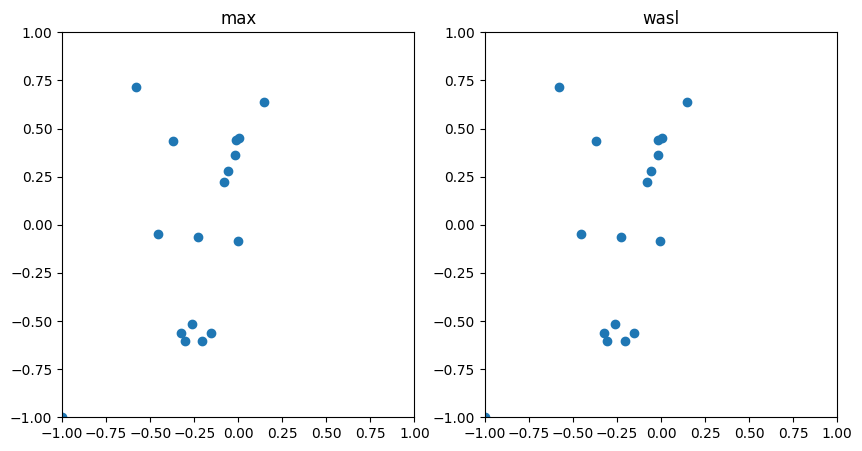

In [133]:
f = 15
p = 17

#[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1
axes[0].scatter(x = vid[f][:, 0][:p], y = vid[f][:, 1][:p])
axes[0].set_title('max')
axes[0].set_xlim(-1, 1)  # Set x-axis limits
axes[0].set_ylim(-1, 1)  # Set y-axis limits


# Plot 2
axes[1].scatter(x = vid[f][:, 0][:p], y = vid[f][:, 1][:p])
axes[1].set_title('wasl')
axes[1].set_xlim(-1, 1)  # Set x-axis limits
axes[1].set_ylim(-1, 1)  # Set y-axis limits

In [ ]:

sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()

        # Bounding box code
        # image, results = mediapipe_detection(frame, holistic)
        # keypoints = extract_keypoints(results)
        # input_img = generate_bounding_box(keypoints, image)
        # display_img = cv2.cvtColor(np.transpose(np.array(input_img), [1, 2, 0]), cv2.COLOR_BGR2RGB)
        # cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 0, 0), 4)

        transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 325)),
          transforms.CenterCrop(224),
          transforms.ToTensor()
        ])
        input_img = transform(frame)
        display_img = np.transpose(np.array(input_img), [1, 2, 0])
        sequence.append(input_img)
        sequence = sequence[-120:]

        if len(sequence) == 120:
          input_sequence = torch.Tensor(np.expand_dims(np.transpose(np.array(sequence), [1, 0, 2, 3]), axis=0))
          with torch.no_grad():
            per_frame_logits = i3d(input_sequence)
          predictions = torch.max(per_frame_logits, dim=2)[0]
          out_labels = np.argsort(predictions.cpu().detach().numpy()[0])
          out_probs = np.sort(predictions.cpu().detach().numpy()[0])

        # chunk1 = video[:, :, i:i+end1, :, :]
        # chunk2 = video[:, :, i:i+end2, :, :]

        # per_frame_logits1 = model(chunk1)
        # per_frame_logits2 = model(chunk2)
        # predictions1 = torch.max(per_frame_logits1, dim=2)[0]
        # p1, k1 = torch.nn.functional.softmax(predictions1, dim = 1).topk(1, dim = 1)
        # predictions2 = torch.max(per_frame_logits2, dim=2)[0]
        # p2, k2 = torch.nn.functional.softmax(predictions2, dim = 1).topk(1, dim = 1)
        # if(p1[0,0].item()>threshold):
        #   i = i+end1
        #   sentence.append(labels[k1[0,0].item()])
        # elif(p2[0,0].item()>threshold):
        #   i = i+end2
        #   sentence.append(labels[k2[0,0].item()])
        # else:
        #   i+=5
        # Show to screen
        cv2.imshow('OpenCV Feed', display_img)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [42]:
top_p, top_k = torch.nn.functional.softmax(per_frame_logits, dim = 2).topk(1, dim = 1)

In [33]:
torch.nn.functional.softmax(per_frame_logits, dim = 2)[0]

tensor([[0.5791, 0.1068, 0.0406,  ..., 0.0120, 0.0174, 0.0576],
        [0.5616, 0.1495, 0.0673,  ..., 0.0083, 0.0176, 0.0590],
        [0.1454, 0.0475, 0.0403,  ..., 0.0375, 0.0547, 0.1735],
        ...,
        [0.4731, 0.1504, 0.0892,  ..., 0.0085, 0.0132, 0.0397],
        [0.3522, 0.3178, 0.1853,  ..., 0.0033, 0.0041, 0.0065],
        [0.4659, 0.1224, 0.0525,  ..., 0.0156, 0.0182, 0.0405]])

In [54]:
print(input_sequence.shape)
print(per_frame_logits.shape)

torch.Size([1, 3, 120, 224, 224])
torch.Size([1, 100, 14])


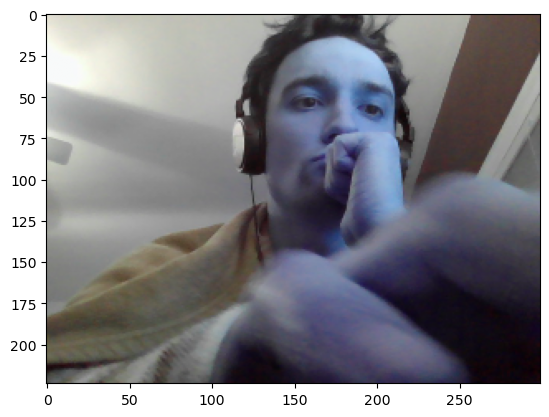

In [19]:
w, h, c = frame.shape
sc = 224 / w
img = cv2.resize(frame, dsize=(0, 0), fx=sc, fy=sc)

img = (img / 255.)

# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img)

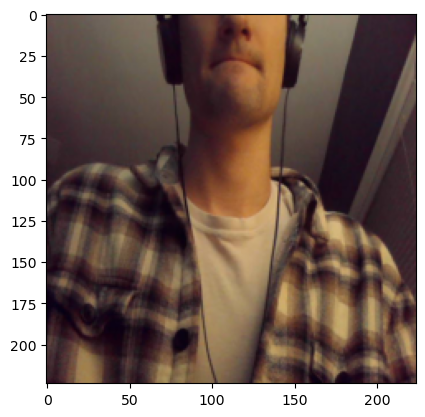

In [32]:

plt.imshow(cv2.cvtColor(np.transpose(np.array(input_img), [1, 2, 0]), cv2.COLOR_BGR2RGB))

In [40]:
np.expand_dims(input_img, axis=0)

array([[[[0.05098039, 0.05098039, 0.04705882, ..., 0.0627451 ,
          0.0627451 , 0.0627451 ],
         [0.05490196, 0.05098039, 0.05490196, ..., 0.06666667,
          0.0627451 , 0.05882353],
         [0.05882353, 0.05882353, 0.05490196, ..., 0.0627451 ,
          0.0627451 , 0.0627451 ],
         ...,
         [0.08235294, 0.08627451, 0.08627451, ..., 0.08235294,
          0.07843138, 0.07843138],
         [0.07843138, 0.07843138, 0.07843138, ..., 0.08235294,
          0.07843138, 0.07843138],
         [0.07450981, 0.07450981, 0.07058824, ..., 0.08235294,
          0.07843138, 0.07843138]],

        [[0.03529412, 0.03529412, 0.02352941, ..., 0.03137255,
          0.03137255, 0.03137255],
         [0.03529412, 0.03137255, 0.02352941, ..., 0.03529412,
          0.03137255, 0.02745098],
         [0.03137255, 0.03137255, 0.02745098, ..., 0.03137255,
          0.03137255, 0.03137255],
         ...,
         [0.03529412, 0.03529412, 0.03529412, ..., 0.03137255,
          0.02745098, 0.0

In [41]:
np.transpose(np.array(input_img), [1, 2, 0]).shape

(224, 224, 3)

In [43]:
input_img.shape

torch.Size([3, 224, 224])

In [23]:
torch.save(i3d.state_dict(), os.path.join('.','model','aslI3D.pth'))

In [ ]:
Pint sized maximum layer  beart